# Evaluación modelos CO y FHMM

Vamos a poner a prueba los modelos de desagregación previamente entrenados en fases anteriores, para los cual deberiamos utilizar un conjunto de datos distinto al usado en el entrenamiento, con tal de aplicar las métricas provistas por NILMTK.

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

## Set de Validación

Ahora tomamos una franja  horaria para validación  que no ha sido utilizada para entrenamiento  

In [2]:
#Set para validación
valid = DataSet('iawe.h5')
valid.set_window(start="2013-07-24 05:30:00", end="2013-08-24 05:30:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[3,4,5,6,7,8,9,10,11])
print(valid_Devices)

Medidor de cabecera para desagregación:
MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
)

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='iAWE', appliances=[Appliance(type='clothes iron', instance=1)])
  ElecMeter(instance=9, building=1, dataset='iAWE', appliance

Ahora marcamos con etiquetas a todos los medidores

In [3]:
labels = pd.DataFrame({'Instances': list(range(1,13)),
                       'Meters': ['M1','M2', 'Fridge', 'AACC', 'AACC', 'Washing machine','Computer','Clothes iron','unknown','tv','wet appliance','motor']})




Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

Y ahora vamos a representarlos datos de la validación para el contador principal

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


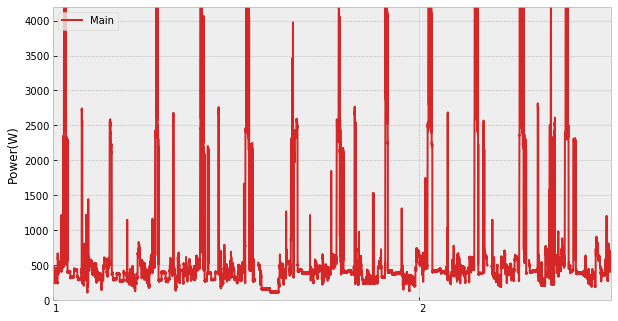

In [21]:
rcParams['figure.figsize'] = (10, 6)

t0='2013-07-24 11:00:00+01:00'
t1='2013-08-01 11:30:00+01:00'
t2='2013-08-24 12:00:00+01:00'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['1','2'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,4200)
plt.savefig('./data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

Asimismo tambien podemos ver el agregado de los diferentes contadores.

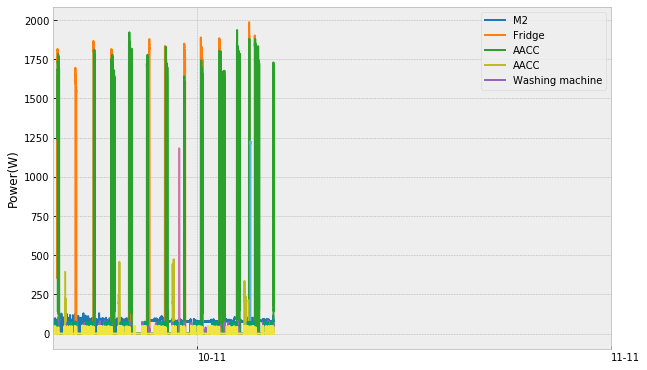

In [22]:
rcParams['figure.figsize'] = (10, 7)

t0='2013-07-24 11:00:00+01:00'
t1='2013-08-01 11:30:00+01:00'
t2='2013-08-24 12:00:00+01:00'

ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[1:6])
ax2.minorticks_off()
ax2.set(xticks=(t1, t2))
ax2.set_xticklabels(labels=['10-11','11-11'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('./data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

### Desagregación para validación

La desagregación de los datos de validación se realiza utilizando los datos del MeterGroup valid_Main, el cual contiene el ElecMeter de los datos agregados del sistema eléctrico. Así, el medidor principal  será el dato de entrada para cada uno de los modelos de desagregación entrenados.


Veamos la degregacion  usando difrentes periodos de sampleo , difrentes metodos  y dos de los algoritmos mas tipicos como es el algoritmo combinatorio (CO) y el de las cadenas de Markovv (FHMM)

In [4]:
train = DataSet('iawe.h5')

train.set_window(start="2013-05-24 05:30:00", end="2013-07-24 07:24:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[3,4,5,6])
train_Devices

from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

periods = {'1s':1, '10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10} #, '15min':60*15, '30min':60*30}
methods = ['mean', 'median','first']

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            #falla al exportarlo como model.pickle asi que lo guardamos en formato h5
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.pickle'
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.h5'
            #model_dir='prueba.pickle'
            #model.export_model(model_dir) 
            
            model_dir=data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5'
            output=HDFDataStore(model_dir, 'w')
            print ('Fichero del modelo:',model_dir)
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            
            #fichaje de los tiempos consumidos
            #end = time.time()-start
            #t.append(round(end,2))
            #print ('Tiempos de proceso:',t)
            
    times[sp_name] = t #tiempo de simulación
   
    
#ValueError: Shape of passed values is (4, 8), indices imply (6, 8)    
times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])


    
    
print('\n\nDone!')

******************** CO 1s mean********************
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])'
Done training!
Fichero del modelo: ./data/NILM/Results/CO_1s_mean_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=1, data

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
******************** CO 1s median********************
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])'
Done training!
Fiche

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
******************** CO 1s first********************
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='

Fichero del modelo: ./data/NILM/Results/FHMM_1s_first_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, data

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10s_mean_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loadi

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10s_median_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10s_first_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_30s_mean_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
D

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_30s_median_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_30s_first_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_60s_mean_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
D

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_60s_median_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_60s_first_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_5min_mean_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_5min_median_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')    

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_5min_first_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10min_mean_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10min_median_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')   

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10min_first_pred.h5
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')    

In [8]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
1s,11.01,124.36,12.65,117.12,11.46,112.09
10s,11.02,23.09,10.43,22.02,10.31,21.79
30s,10.23,15.35,10.29,15.65,10.24,15.41
60s,9.93,12.88,9.93,12.83,9.81,12.45
5min,9.94,10.38,9.47,10.41,9.48,10.27
10min,9.23,10.02,9.33,10.05,9.27,10.03
